In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import NMF
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
import time
from collections import defaultdict

In [2]:
dataset = pd.read_csv("dataset_recommendation.csv", sep=";")

In [3]:
dataset.columns

Index(['customer_unique_id', 'product_id', 'review_score',
       'product_category_name'],
      dtype='object')

In [4]:
#GET SHAPE
rows_count, columns_count = dataset.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)

Total Number of rows : 100801
Total Number of columns : 4


In [5]:
#UNIQUE VALUES
unique_userId = dataset['customer_unique_id'].nunique()
unique_productId = dataset['product_id'].nunique()
print('Total number of unique Users    : ', unique_userId)
print('Total number of unique Products : ', unique_productId)

Total number of unique Users    :  94006
Total number of unique Products :  32541


Check for NaN values, you never know!

In [6]:
dataset.apply(lambda x : sum(x.isna()))

customer_unique_id       0
product_id               0
review_score             0
product_category_name    0
dtype: int64

Lets see at the distribution of the reviews

In [7]:
#Dataset with n of reviews for each label
rating_counts = pd.DataFrame(dataset['review_score'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5,58254
1,4,19428
2,1,11577
3,3,8330
4,2,3212


Plot them

C:\Users\marco\anaconda3\envs\datavis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


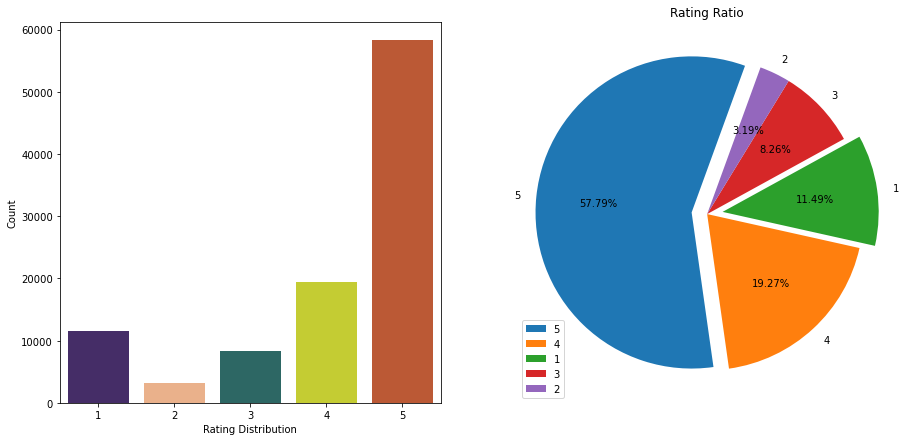

In [8]:
#graph review
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(dataset['review_score'], ax=ax1, palette=['#432371',"#FAAE7B", "#23716d", "#dbe619", "#d14f1f"])
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)

explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_counts["Ratings"], explode=explode, labels=rating_counts.Labels, autopct='%1.2f%%',
        shadow=False, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_counts.Labels, loc=3)
plt.show()

## Popularity Recommeder model

Reccomendation systems based on popularity are an easy way to target new customers and solve the so called "cold-start" problem. Clearly they do not take into account the single preferences of the users but can be useful to improve sales and consequently have more data and reviews to work with.

#### Mean of products rating

In [135]:
df_rec = dataset.copy()

In [136]:
df_rec.groupby("product_id")["review_score"].mean().head(10)

product_id
00066f42aeeb9f3007548bb9d3f33c38    5.000000
00088930e925c41fd95ebfe695fd2655    5.000000
0009406fd7479715e4bef61dd91f2462    5.000000
000b8f95fcb9e0096488278317764d19    4.500000
000d9be29b5207b54e86aa1b1ac54872    3.000000
0011c512eb256aa0dbbb544d8dffcf6e    4.000000
00126f27c813603687e6ce486d909d01    5.000000
001795ec6f1b187d37335e1c4704762e    4.714286
001b237c0e9bb435f2e54071129237e9    5.000000
001b72dfd63e9833e8c02742adf472e3    4.416667
Name: review_score, dtype: float64

Sorts products by their mean review

In [137]:
df_rec.groupby("product_id")["review_score"].mean().sort_values(ascending=False).head(10)

product_id
00066f42aeeb9f3007548bb9d3f33c38    5.0
86003fbbec2202f29e74ada517cec5a8    5.0
85f7420fa40ab8ab0d46096ecbecb0b7    5.0
85f709dd4e8f207aecdfaeba8581c1f0    5.0
85f32a430567418e5a6a480a12067e9b    5.0
85f2efd301728b2f8f012f776d932fa2    5.0
85ec69dc21ef2674bd946f3a6adc01b3    5.0
85e8e8aad6ad12d67c21300379760196    5.0
85e47c36b9e15522778da086983e41f4    5.0
85e0d0758fddf0f8f33fa73153b1e226    5.0
Name: review_score, dtype: float64

Add the number of reviews the product got.

In [138]:
prod_rating_count = pd.DataFrame(df_rec.groupby('product_id')['review_score'].mean().sort_values(ascending=False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(df_rec.groupby('product_id')['review_score'].count())
prod_rating_count.head()

,review_score,prod_rating_count
product_id,,
00066f42aeeb9f3007548bb9d3f33c38,5.0,1
86003fbbec2202f29e74ada517cec5a8,5.0,2
85f7420fa40ab8ab0d46096ecbecb0b7,5.0,1
85f709dd4e8f207aecdfaeba8581c1f0,5.0,3
85f32a430567418e5a6a480a12067e9b,5.0,3


Sort the "prod_rating_count" to have the top 10 popular products for the recommendation.

In [139]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)
basic_poplurity_model.head(10)

,review_score,prod_rating_count
product_id,,
99a4788cb24856965c36a24e339b6058,4.058952,458
aca2eb7d00ea1a7b8ebd4e68314663af,4.016317,429
422879e10f46682990de24d770e7f83d,4.179487,351
d1c427060a0f73f6b889a5c7c61f2ac4,4.209375,320
389d119b48cf3043d311335e499d9c6b,4.096774,310
53b36df67ebb7c41585e8d54d6772e08,4.003300,303
368c6c730842d78016ad823897a372db,4.103806,289
53759a2ecddad2bb87a079a1f1519f73,4.070175,285
154e7e31ebfa092203795c972e5804a6,4.082090,268


Plot average ratings against the number of ratings

<Figure size 2160x1440 with 0 Axes>

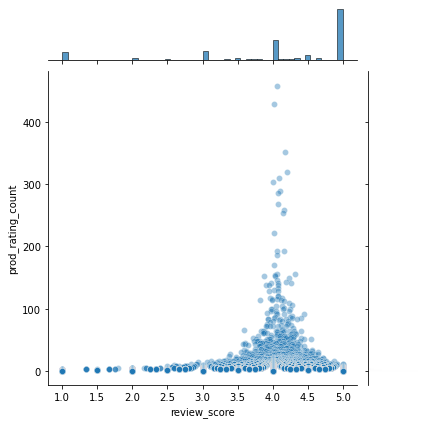

In [140]:
plt.figure(figsize=(30,20))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='review_score', y='prod_rating_count', data=basic_poplurity_model, alpha=0.4)

The graph shows that the majority of rieviews is five. There are some products tha received a higher than normal number of rating and they have as mean review score between 3.5 and 4.5.

### Ranking-Based Algorithms

Another simple way is through a simple ranking system, based on the higher product count.

In [141]:
panda_data_grouped = df_rec.groupby('product_id').agg({'customer_unique_id': 'count'}).reset_index()
panda_data_grouped.rename(columns = {'customer_unique_id': 'score'},inplace=True)
panda_data_grouped.head()

,product_id,score
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1


In [142]:
#Sort the products on recommendation score
panda_data_sort = panda_data_grouped.sort_values(['score', 'product_id'], ascending = [0,1])

In [143]:
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending=0, method='first')

In [144]:
popularity_recommendations = panda_data_sort.head(10)
popularity_recommendations

,product_id,score,Rank
19497,99a4788cb24856965c36a24e339b6058,458,1.0
21838,aca2eb7d00ea1a7b8ebd4e68314663af,429,2.0
8487,422879e10f46682990de24d770e7f83d,351,3.0
26711,d1c427060a0f73f6b889a5c7c61f2ac4,320,4.0
7258,389d119b48cf3043d311335e499d9c6b,310,5.0
10716,53b36df67ebb7c41585e8d54d6772e08,303,6.0
6982,368c6c730842d78016ad823897a372db,289,7.0
10690,53759a2ecddad2bb87a079a1f1519f73,285,8.0
2759,154e7e31ebfa092203795c972e5804a6,268,9.0
5618,2b4609f8948be18874494203496bc318,259,10.0


Using popularity based recommender model to make predictions and find recommendations for random list of users with inferences

In [126]:
import warnings

In [127]:
warnings.filterwarnings('ignore')
def recommend(user_id):
    user_recommendations = popularity_recommendations

    #Adding user_id column for which the recommendations are being generated
    user_recommendations['user_id'] = user_id

    #Bringing user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [128]:
find_recom = ["9b74eb2e52bbbb88985c2fb43e02beae"]   # This list is user choice.
for i in find_recom:
    print("This is the recommendation for the user_id: %s\n" % i)
    print(recommend(i))
    print("\n")

This is the recommendation for the user_id: 9b74eb2e52bbbb88985c2fb43e02beae

                                user_id                        product_id  \
19497  9b74eb2e52bbbb88985c2fb43e02beae  99a4788cb24856965c36a24e339b6058   
21838  9b74eb2e52bbbb88985c2fb43e02beae  aca2eb7d00ea1a7b8ebd4e68314663af   
8487   9b74eb2e52bbbb88985c2fb43e02beae  422879e10f46682990de24d770e7f83d   
26711  9b74eb2e52bbbb88985c2fb43e02beae  d1c427060a0f73f6b889a5c7c61f2ac4   
7258   9b74eb2e52bbbb88985c2fb43e02beae  389d119b48cf3043d311335e499d9c6b   
10716  9b74eb2e52bbbb88985c2fb43e02beae  53b36df67ebb7c41585e8d54d6772e08   
6982   9b74eb2e52bbbb88985c2fb43e02beae  368c6c730842d78016ad823897a372db   
10690  9b74eb2e52bbbb88985c2fb43e02beae  53759a2ecddad2bb87a079a1f1519f73   
2759   9b74eb2e52bbbb88985c2fb43e02beae  154e7e31ebfa092203795c972e5804a6   
5618   9b74eb2e52bbbb88985c2fb43e02beae  2b4609f8948be18874494203496bc318   

       score  Rank  
19497    458   1.0  
21838    429   2.0  
8487     35


Comment: **Top 10 popular products**:

(99a4788cb24856965c36a24e339b6058,36f60d45225e60c7da4558b070ce4b60,e53e557d5a159f5aa2c5e995dfdf244b,389d119b48cf3043d311335e499d9c6b,
154e7e31ebfa092203795c972e5804a6,422879e10f46682990de24d770e7f83d,53759a2ecddad2bb87a079a1f1519f73,368c6c730842d78016ad823897a372db,35afc973633aaeb6b877ff57b2793310,2b4609f8948be18874494203496bc318).

Since this is a **popularity-based** recommender model, recommendations remain the same for all users. We predict the products based on the popularity. **It is not personalized to
particular user**.

## COLLABORATIVE FILTERING MODEL

The dataset is subsetted in a smaller matrix with only people who reviewed at least 2 product, and products receiving at leas two reviews. It is done in order to scale-down the sparsity of the dataframe.

In [24]:
#SUBSETTING THE DATASET
df_start = dataset.drop(["product_category_name"], axis=1)

users_counts = df_start['customer_unique_id'].value_counts().rename('users_counts')
users_data   = df_start.merge(users_counts.to_frame(),
                                left_on='customer_unique_id',
                                right_index=True)
subset_df = users_data[users_data.users_counts >= 2]


In [25]:
#product with at least two reviews
product_rating_counts = subset_df['product_id'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='product_id',
                                right_index=True)
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 2]

In [26]:
product_rating_data.shape

(394, 5)

<AxesSubplot:xlabel='product_id', ylabel='customer_unique_id'>

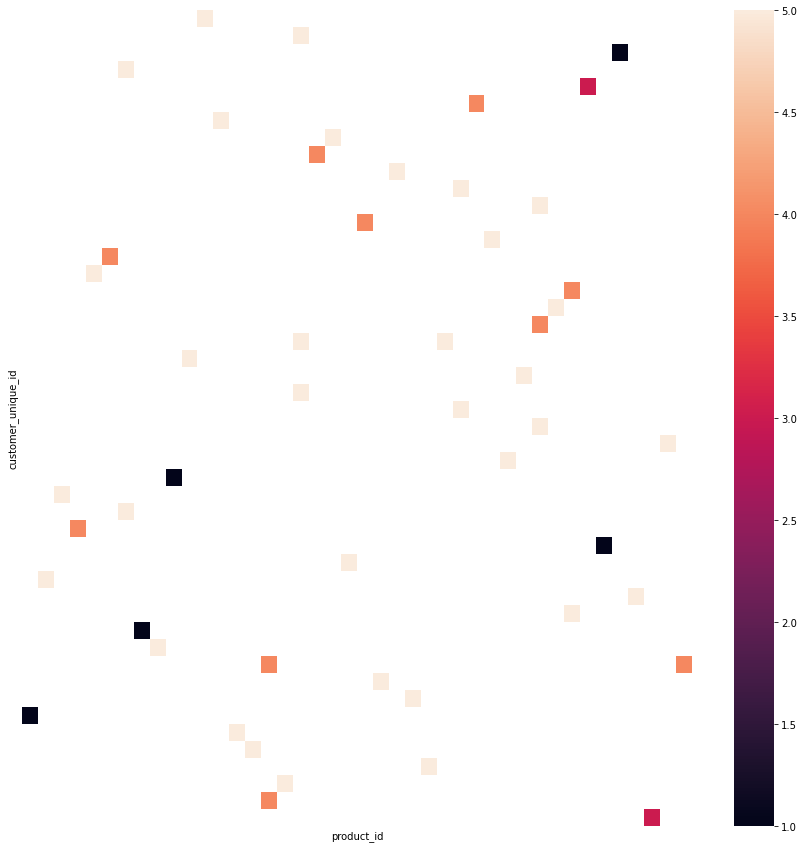

In [27]:
# take a 1000 sample of the data
data_sample = product_rating_data.sample(50)

# plot the data user_id vs item_id
plt.figure(figsize=(15,15))
sns.heatmap(data_sample.pivot_table(index='customer_unique_id', columns='product_id', values='review_score'), fmt='.1f',
            xticklabels=False, yticklabels=False)

In [11]:
#START
df1 = product_rating_data.copy()

panda_data = df1.drop(['users_counts', 'product_rating_counts'], axis=1)#remove the useless columns

reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(panda_data[['customer_unique_id', 'product_id', 'review_score']], reader)#transforming so surprise format
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=42) #test and train set

In [12]:
cv_results = [] #list to store result

Find the best parameters for the two SVD models using grid-search

In [13]:
#BEST PARAMETERS FOR SVD

svd_param_grid = {'n_epochs': [15,20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)

# best RMSE score
print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

1.3570368998279139
1.3566769326361434
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.6}
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.6}


Find best params for the NMF model using grid-search

In [63]:
#BEST PARAMS FOR Non-negative Matrix Factorization
NMF_param_grid = {'n_factors': [1000,1100], 'n_epochs': [18]}
NMF_gs = GridSearchCV(NMF, NMF_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

NMF_gs.fit(surprise_data)

#RMSE
print(NMF_gs.best_score["rmse"])
#PARAMETERS
print(NMF_gs.best_params["rmse"])

1.559576271388396
{'n_factors': 1000, 'n_epochs': 18}


SVD MODEL

In [14]:
#SVD
start_time = time.time()

# Creating Model using best parameters
svd_model = SVD(n_epochs=20, lr_all=0.007, reg_all=0.6)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'],
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


# get RMSE/MAE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
accuracy.mae(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
print(cv_results)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3505  1.3555  1.3562  1.3703  1.3552  1.3575  0.0067  
MAE (testset)     1.0649  1.0671  1.0666  1.0736  1.0675  1.0679  0.0030  
Fit time          8.82    10.20   9.94    8.58    9.25    9.36    0.62    
Test time         0.21    0.39    0.42    0.27    0.29    0.32    0.08    


==================== Model Evaluation ===============================
RMSE: 1.3483
MAE:  1.0612

 Computational Time : 61.323s
  Model      RMSE       MAE  Fit Time  Test Time
0   SVD  1.357541  1.067944   9.35771   0.316828


SVD++ Model

In [69]:
#

start_time = time.time()
# Creating Model using best parameters
svdpp_model = SVDpp(n_epochs=20, lr_all=0.007, reg_all=0.6)

# Training the algorithm on the trainset
svdpp_model.fit(trainset)

# Predicting for test set
predictions_svdpp = svdpp_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()
svdpp_cv_results = pd.DataFrame([['SVDpp', svdpp_described['test_rmse']['mean'], svdpp_described['test_mae']['mean'],
                           svdpp_described['fit_time']['mean'], svdpp_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(svdpp_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svdpp, verbose=True)
accuracy.mae(predictions_svdpp, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
print(cv_results)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3621  1.3733  1.3325  1.3696  1.4286  1.3732  0.0312  
MAE (testset)     1.0786  1.0859  1.0660  1.0714  1.1278  1.0859  0.0220  
Fit time          1.17    1.17    1.38    1.12    1.11    1.19    0.10    
Test time         0.02    0.05    0.05    0.03    0.03    0.04    0.01    


==================== Model Evaluation ===============================
RMSE: 1.3565
MAE:  1.0824

 Computational Time : 8.164s
   Model      RMSE       MAE  Fit Time  Test Time
0    SVD  1.377467  1.087971  0.864067   0.021803
1  SVDpp  1.373221  1.085934  1.190690   0.036597


NMF MODEL

In [71]:
start_time = time.time()
# Creating Model using best parameters
nmf_model = NMF(n_epochs=18, n_factors=1000)

# Training the algorithm on the trainset
nmf_model.fit(trainset)

# Predicting for test set
predictions_nmf = nmf_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
nmf_cv = cross_validate(nmf_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
nmf_df = pd.DataFrame.from_dict(nmf_cv)
nmf_described = nmf_df.describe()
nmf_cv_results = pd.DataFrame([['NMF', nmf_described['test_rmse']['mean'], nmf_described['test_mae']['mean'],
                           nmf_described['fit_time']['mean'], nmf_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(nmf_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_nmf, verbose=True)
accuracy.mae(predictions_nmf, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
print(cv_results)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5278  1.5984  1.4957  1.5758  1.5159  1.5427  0.0383  
MAE (testset)     1.0395  1.0829  1.0046  1.0481  1.0107  1.0371  0.0282  
Fit time          20.96   24.77   21.67   22.92   18.90   21.84   1.96    
Test time         0.03    0.01    0.03    0.01    0.03    0.02    0.01    


==================== Model Evaluation ===============================
RMSE: 1.5061
MAE:  1.0412

 Computational Time : 130.287s
   Model      RMSE       MAE   Fit Time  Test Time
0    SVD  1.377467  1.087971   0.864067   0.021803
1  SVDpp  1.373221  1.085934   1.190690   0.036597
2    NMF  1.373221  1.085934   1.190690   0.036597
3    NMF  1.542691  1.037138  21.843130   0.022411


In [42]:
#KNN OPTIMAL PARAMS
start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [10, 15],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)


knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

# best RMSE score
print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])

computational_time = time.time() - start_time
print('\nComputational Time : %0.3fs' %(computational_time))

MemoryError: Unable to allocate 94.8 MiB for an array with shape (3525, 3525) and data type float64

In [72]:
#KNN BASIC-UU WITH SIMILARITIES BETWEEN USERS
start_time = time.time()
knnBasic_model = KNNBasic(k=15,sim_options= {'name': 'pearson_baseline',
                                             'user_based': True} # compute  similarities between users
                          )

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv_U = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv_U)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasicUserBased', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'],
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
accuracy.mae(prediction_knnBasic, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
print(cv_results)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4390  1.4135  1.4599  1.3986  1.4206  1.4263  0.0212  
MAE (testset)     1.1061  1.0878  1.1169  1.0783  1.0949  1.0968  0.0135  
Fit time      

In [73]:
#KNN BASIC-II WITH SIMILARITIES BETWEEN ITEMS
start_time = time.time()
knnBasic_model = KNNBasic(k=15,sim_options= {'name': 'pearson_baseline',
                                             'user_based': False} # compute  similarities between items
                          )

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv_I = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv_I)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasicItemBased', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'],
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
accuracy.mae(prediction_knnBasic, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
print(cv_results)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4122  1.4651  1.4917  1.4010  1.4230  1.4386  0.0343  
MAE (testset)     1.0794  1.1214  1.1421  1.0704  1.0803  1.0987  0.0280  
Fit time      

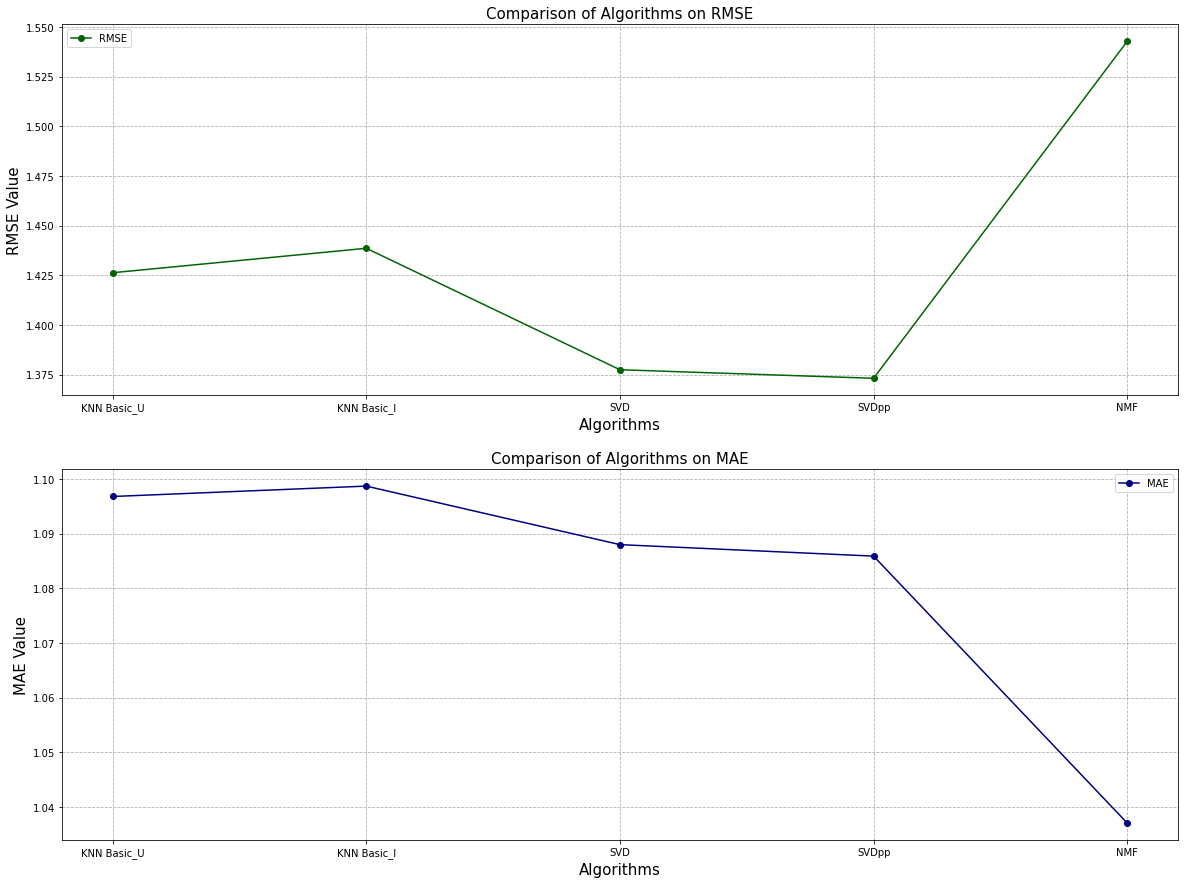

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,1.377467,1.087971,0.864067,0.021803
1,SVDpp,1.373221,1.085934,1.190690,0.036597
2,NMF,1.373221,1.085934,1.190690,0.036597
3,NMF,1.542691,1.037138,21.843130,0.022411
4,KNNBasicUserBased,1.426319,1.096798,1.035482,0.028799
5,KNNBasicItemBased,1.438581,1.098694,0.218224,0.024801


<Figure size 432x288 with 0 Axes>

In [83]:
x_algo = ['KNN Basic_U',"KNN Basic_I",'SVD', 'SVDpp', "NMF"]
all_algos_cv = [knnBasic_cv_U, knnBasic_cv_I, svd_cv, svdpp_cv, nmf_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv  = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,15))

plt.subplot(2, 1, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(2, 1, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()
plt.savefig("metric.jpg")
cv_results

The following function will create a pandas data frame which will consist of these columns:

UID: user-id

iid: item id

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [106]:
def get_Iu(uid):
    """
    args:
      uid: the id of the user
    returns:
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0

def get_Ui(iid):
    """
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0


df_predictions = pd.DataFrame(predictions_svdpp, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [107]:
df_predictions.head(10)

,uid,iid,rui,est,details,Iu,Ui,err
0,b2bd387fdc3cf05931f0f897d607dc88,36f60d45225e60c7da4558b070ce4b60,5.0,4.217069,{'was_impossible': False},5,65,0.782931
1,318dd674b6e789249337a1edca1b0cc1,35afc973633aaeb6b877ff57b2793310,5.0,3.946938,{'was_impossible': False},1,35,1.053062
2,f30856ad31d3e74253a3f4ccef670648,36f60d45225e60c7da4558b070ce4b60,5.0,4.088343,{'was_impossible': False},2,65,0.911657
3,26a9b95058d46f1e6a685688355a1cdb,4a37fea9a17c3cb688dc22802a698a80,5.0,4.015239,{'was_impossible': False},1,1,0.984761
4,40aff2666e4f64f660c941072c6e2521,5c692818d313aa12864b48ac0c2472c2,5.0,4.229799,{'was_impossible': False},2,5,0.770201
5,f4af0b3f627879bf6801db96949b1e71,ace5d86cf1ac63cdb76f49e5cd23d2f8,5.0,3.782276,{'was_impossible': False},1,4,1.217724
6,cf4935767b14a8312de405de5d5bbdb5,36f60d45225e60c7da4558b070ce4b60,2.0,4.131605,{'was_impossible': False},0,65,2.131605
7,4d5cbb095f36a674f6f4a852959ad11d,158102fe543dbaeb84d87811bfe06d0d,5.0,3.436467,{'was_impossible': False},1,4,1.563533
8,7bff4fff725edd40fde6f0ac1eb0e2dc,283dc451ad3918badb976d56ff887289,1.0,4.360970,{'was_impossible': False},4,8,3.360970
9,65942a39d31e4aa627f0f65e0298ba2f,36f60d45225e60c7da4558b070ce4b60,5.0,3.653786,{'was_impossible': False},1,65,1.346214


Top-10 predictions

In [109]:
best_predictions = df_predictions.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1138,71f5d6c0cf885d0b2b52836a4c469bc3,937d4dbe97dc4cda39683025976f91ae,4.0,4.006779,{'was_impossible': False},1,1,0.006779
1497,2b5c14b7e1a3d88ff7e0c46e15851f5f,7c1bd920dbdf22470b68bde975dd3ccf,4.0,3.990299,{'was_impossible': False},1,24,0.009701
1735,3329202f1e357ad78ad4bbc14f3f658a,fb783e3e545937820b57fe539b2c5a6c,4.0,3.989704,{'was_impossible': False},3,4,0.010296
766,75bbb6b481a1df1689bb769e63ec3acb,154e7e31ebfa092203795c972e5804a6,4.0,4.011997,{'was_impossible': False},2,41,0.011997
14,51d8d985d769925b981b4a34ddf6dfc6,f1c7f353075ce59d8a6f3cf58f419c9c,4.0,3.986496,{'was_impossible': False},1,6,0.013504
500,b53b27d7c61cc80d2b2eaf6f1ff8a861,ecbe1ef7e2903ff8b1d704ba78fa264d,4.0,3.985669,{'was_impossible': False},2,5,0.014331
1280,4f0c8db463d2261888faa81900eb33c1,df3655ac9aa8c6cbfa63bdd8d3b09c50,4.0,4.014832,{'was_impossible': False},2,2,0.014832
1619,1118a7bb7ba893f10740e22a23aa5bd9,ec2d43cc59763ec91694573b31f1c29a,4.0,4.017554,{'was_impossible': False},1,16,0.017554
653,075c38f7a650b0dc822712c7a58e93d4,ec2d43cc59763ec91694573b31f1c29a,4.0,4.017554,{'was_impossible': False},1,16,0.017554
383,d24e1d0902dac57dd313bcf4f9c80160,2c71438371b35f7ce3c2511d6b0927e7,4.0,4.018937,{'was_impossible': False},3,3,0.018937


In [85]:
k = 5
top_n = defaultdict(list)
def get_top_n(predictions, n=k):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svdpp, n=k)
top_n

defaultdict(list,
            {'b2bd387fdc3cf05931f0f897d607dc88': [('99f5b2240b82bf9387e5cf2fc0335b08',
               4.321444142032917),
              ('e3323b0d3f79bdf85b58561d2218bc12', 4.248117340693003),
              ('36f60d45225e60c7da4558b070ce4b60', 4.217068830802966)],
             '318dd674b6e789249337a1edca1b0cc1': [('99a4788cb24856965c36a24e339b6058',
               4.052506362265654),
              ('35afc973633aaeb6b877ff57b2793310', 3.9469375269651295)],
             'f30856ad31d3e74253a3f4ccef670648': [('36f60d45225e60c7da4558b070ce4b60',
               4.088342555462967)],
             '26a9b95058d46f1e6a685688355a1cdb': [('4a37fea9a17c3cb688dc22802a698a80',
               4.015239277923718)],
             '40aff2666e4f64f660c941072c6e2521': [('5c692818d313aa12864b48ac0c2472c2',
               4.229799061582755)],
             'f4af0b3f627879bf6801db96949b1e71': [('ace5d86cf1ac63cdb76f49e5cd23d2f8',
               3.7822761569783445)],
             'cf4935767b14a83